## MCX simulation

In [2]:
! pip install pmcx
!pip install numpy pmcx jdata bjdata matplotlib
import pmcx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.2 MB/s eta 0:00:00
Cloning into 'mcx'...
remote: Enumerating objects: 13205, done.
remote: Counting objects: 100% (2745/2745), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 13205 (delta 2583), reused 2509 (delta 2508), pack-reused 10460 (from 3)
Receiving objects: 100% (13205/13205), 25.16 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (9196/9196), done.
Submodule 'filter' (https://github.com/fangq/GPU-ANLM.git) registered for path 'filter'
Submodule 'src/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'src/pybind11'
Cloning into '/content/mcx/filter'...
remote: Enumerating objects: 117, done.        
remote: Counting objects: 100% (10/10), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 117 (delta 4), reused 4 (delta 2), pack-reused 107 (from 1)        
Receiving objects: 100% (117/117), 3.66 MiB | 36.38 MiB/s, done.
Resolving deltas: 100% (59/5

In [3]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation

In [4]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [5]:
n = 1.370
c = 2.998e+10
c = c / n # cm/s

In [6]:
#  prop=np.array([[0, 0, 1, 1], [0.005, 1, 0.01, 1.37]])) : [μa=0.005, μs=1, g=0.01, n=1.37]

vol = np.ones([100, 100, 100], dtype='uint8')
vol[:, :, 0:1] = 0
vol[:, :, 1:] = 1

# define the boundary:
vol[:, :, 0] = 0
vol[:, :, 99] = 0
vol[0, :, :] = 0
vol[99, :, :] = 0
vol[:, 0, :] = 0
vol[:, 99, :] = 0

prop = np.array([
    [0.0, 0.0, 1.0, 1.0], # air
    [0.03, 9, 0.85, n], #
])

cfg = {
      'nphoton': 100000000,  # 100M photons
      'vol': vol, # 100x100x100 mm in size.
      'tstart': 0, # start time = 0
      'tend': 1e-08, # end time
      'tstep': (1e-8 / 1000), # step size = 1 picoseconds
      'srcpos': [50, 50, 1],
      'srcdir': [0, 0, 1],  # Pointing toward z=1
      'prop': prop,  # mediums.
      'detpos': [[65, 50, 1, 2]],  # Single detector radius 2 mm, 1.5 cm far away from the light source.
      'savedetflag': 'dpxsvmw',  # Save detector ID, exit position, exit direction, partial path lengths
      'unitinmm': 1,
      'autopilot': 1,
      'debuglevel': 'DP',

      # change to isotropic source:
      'srctype': 'isotropic',
      #'tmod': mf,
}

cfg['issaveref']=1
cfg['issavedet']=1
cfg['issrcfrom0']=1
cfg['maxdetphoton']=1000000

# Run the simulation
res = pmcx.mcxlab(cfg)
print(res['stat'])
print("Result keys:", list(res.keys()))
print('detp keys:', res['detp'].keys())

nphoton: 1e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
{'runtime': 10164, 'nphoton': 100000000, 'energytot': 100000000.0, 'energyabs': 36925247.95562744, 'normalizer': 1000.0, 'unitinmm': 1.0, 'workload': [6912.0]}
Result keys: ['detp', 'dref', 'flux', 'stat']
detp keys: dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])


In [9]:
res.keys()
tstep = cfg['tstep']

In [10]:
# res['dref'] = X weights/tstep/photon_released(1e8)
# sum(X weights/tstep) in all tstep = % of energy (compared with 1e8)
en = np.sum(res['dref'][:, :, 0, :])+ np.sum(res['dref'][:, :, 99, :])+ np.sum(res['dref'][0, :, :, :])+ np.sum(res['dref'][99, :, :, :]) + np.sum(res['dref'][:, 0, :, :])+ np.sum(res['dref'][:, 99, :, :])
# % of energy reflect outside of the box:
print('% of energy reflect outside: %', en*tstep*100)
print('% of energy lost: %', 100-en*tstep*100)

% of energy reflect outside: % 63.07469
% of energy lost: % 36.92531


In [11]:
r = np.pi*(15**2)/(99*99*99)
print(r*en)

45949620.0


### Extract the time domain info

In [12]:
# define the mask:
det_x, det_y, det_z, det_r = cfg['detpos'][0]
# Generate a 2D mask for the detector area in x-y plane (z=1)
nx, ny, nz, nt = res['dref'].shape
x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
det_mask = (x_grid - det_x)**2 + (y_grid - det_y)**2 <= det_r**2

In [13]:
area = np.sum(det_mask)
print(area)

13


In [51]:
dref_per_time = []
for t in range(res['dref'].shape[3]):
    dref_slice = res['dref'][:, :, 0, t]
    masked_values = dref_slice[det_mask]
    mean_val = np.sum(masked_values)
    dref_per_time.append(mean_val)
print(len(dref_per_time))

1000


In [14]:
# sum_dref_per_time[x] =  X weights/tstep/photon_released(1e8) in detector
sum_dref_per_time = []
for t in range(res['dref'].shape[3]):
    dref_slice = res['dref'][:, :, 0, t]
    masked_values = dref_slice[det_mask]
    mean_val = np.sum(masked_values) * tstep * 1e8
    sum_dref_per_time.append(mean_val)
print(len(sum_dref_per_time))

1000


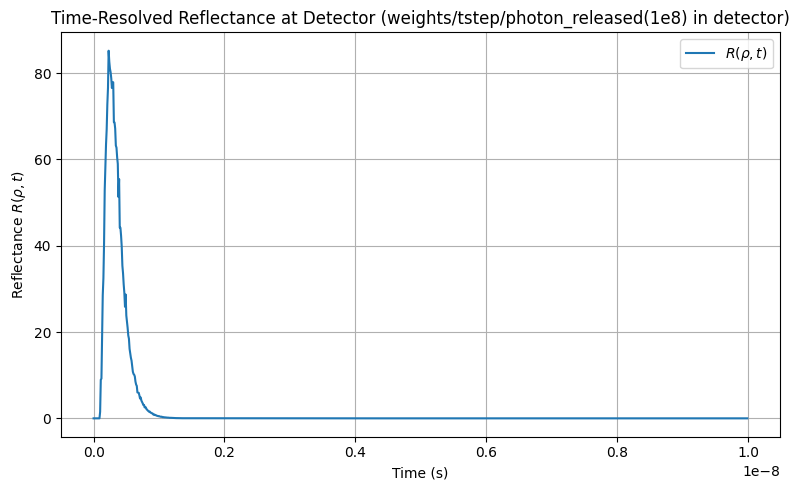

In [50]:
import numpy as np
import matplotlib.pyplot as plt

tstep = cfg['tstep']
nt = len(sum_dref_per_time)
time_s = np.arange(0, nt) * tstep

# Convert reflectance to numpy array (if needed)
sum_dref_per_time = np.array(sum_dref_per_time)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(time_s, sum_dref_per_time, label=r"$R(\rho, t)$")
plt.xlabel("Time (s)")
plt.ylabel("Reflectance $R(\\rho, t)$")
plt.title("Time-Resolved Reflectance at Detector (weights/tstep/photon_released(1e8) in detector)")
plt.grid(True)
#plt.xlim(0, 0.1e-8)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# how much energy(%) distributed in the detector overall from emittion.
# emission: 1e8 photons x 1 weighst per photon
# received (weights) in each t_step: sum_dref_per_time
# percentage of energy: sum_dref_per_time/ 1e8
print(sum(sum_dref_per_time))
print(sum(sum_dref_per_time)/1e8)
print(f'for every release photon, only find {sum(sum_dref_per_time)/1e8} in detector')

2408.7275
2.4087276e-05
for every release photon, only find 2.4087275960482657e-05 in detector


In [17]:
len(sum_dref_per_time)

1000

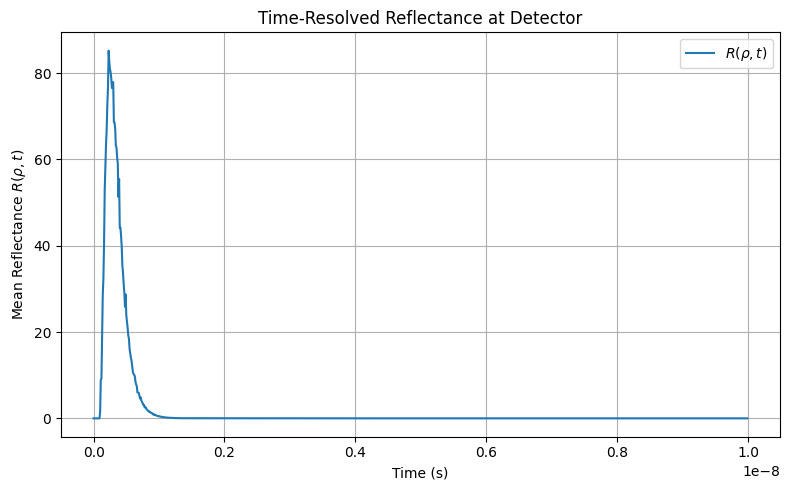

In [18]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(time_ns, sum_dref_per_time, label=r"$R(\rho, t)$")
plt.xlabel("Time (s)")
plt.ylabel("Mean Reflectance $R(\\rho, t)$")
plt.title("Time-Resolved Reflectance at Detector")
plt.grid(True)
#plt.xlim(0, 0.1e-8)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
time_s = time_ns * 1e-9          # ns  →  s
area_trapz   = np.trapz(sum_dref_per_time, x=time_s)          # trapezoidal
print(f"Area (trapz)  = {area_trapz:.6g}")

Area (trapz)  = 2.40873e-17


<ipython-input-19-0546df919fee>:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_trapz   = np.trapz(sum_dref_per_time, x=time_s)          # trapezoidal


### Verification

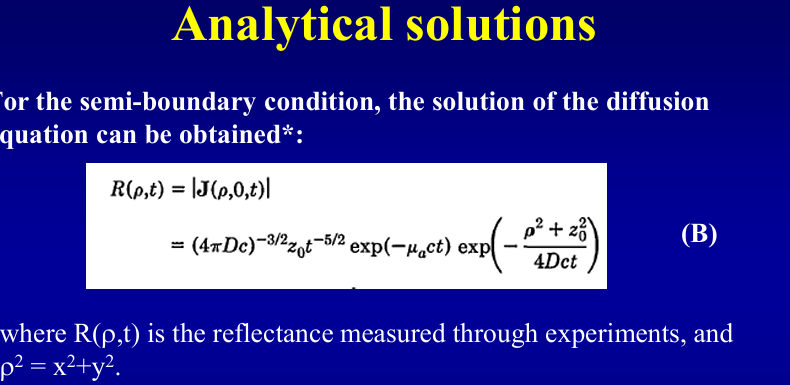

In [20]:
log_dref_per_time_ln = [np.log(x) for x in sum_dref_per_time]
print(len(log_dref_per_time_ln))

1000


<ipython-input-20-3880eae8ac95>:1: RuntimeWarning: divide by zero encountered in log
  log_dref_per_time_ln = [np.log(x) for x in sum_dref_per_time]


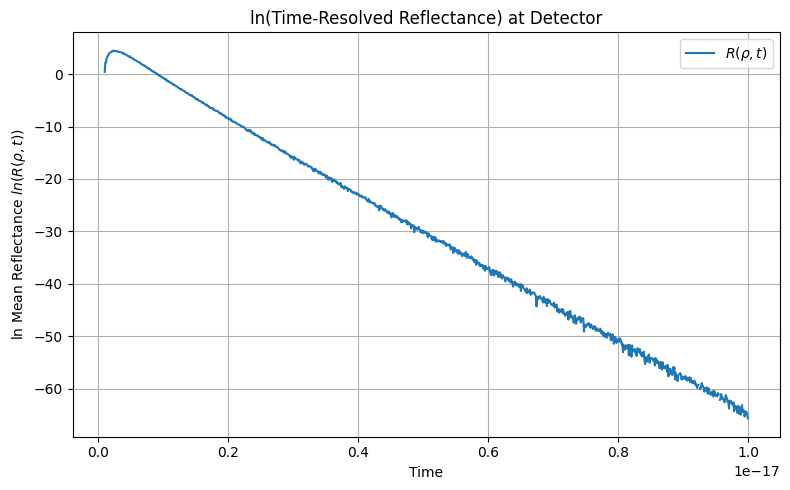

In [21]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(time_s, log_dref_per_time_ln, label=r"$R(\rho, t)$")
plt.xlabel("Time")
plt.ylabel("ln Mean Reflectance $ln(R(\\rho, t))$")
plt.title("ln(Time-Resolved Reflectance) at Detector")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def compute_slope(x1, y1, x2, y2):
  if x2 != x1:
      return (y2 - y1) / (x2 - x1)
  else:
      return None

In [23]:
tstep = cfg['tstep']
ua = -(compute_slope(cfg['tstep'] * 100, log_dref_per_time_ln[100], cfg['tstep']*350, log_dref_per_time_ln[350]))/(c*10)
print('ua=', ua,'/mm-1')
print('ua=',ua*10,'/cm-1')

ua= 0.034883946 /mm-1
ua= 0.34883946 /cm-1


### MCX vs Formula

$$
R(\rho, t) = \left| \mathbf{J}(\rho, 0, t) \right| = (4\pi D c)^{-3/2} z_0 t^{-5/2} \cdot \exp(-\mu_a c t) \cdot \exp\left( -\frac{\rho^2 + z_0^2}{4 D c t} \right)
$$

In [24]:

def R_rho_t(t, ua, c, D, z0, rho=1.5):
    # Avoid division by zero for t = 0
    t = np.where(t == 0, np.finfo(float).eps, t)  # Replace 0 with a small number

    # Prefactor: (4 * pi * D * c) ** (-3/2)
    A = (4 * np.pi * D * c) ** (-1.5)

    # z0 * t ** (-5/2)
    T = z0 * (t ** (-2.5))

    # Exponential terms
    exp1 = np.exp(-ua * c * t)
    exp2 = np.exp(-(rho**2 + z0**2) / (4 * D * c * t))

    # Return the product
    return A * T * exp1 * exp2

In [25]:
# ------ optical coefficients in cm-1 (your current values) -----------------
ua_cm = 0.03 * 10     # 0.30 cm-1
us_cm = 9    * 10     # 90  cm-1
g     = 0.85

# ------ convert to mm-1 for MCX comparison ---------------------------------
ua  = ua_cm / 10      # 0.030 mm-1
us  = us_cm / 10      # 9.0   mm-1

# diffusion parameters (mm, mm-1)
D   = 1 / (3 * (ua + us * (1 - g)))              # mm
z0  = 1 / (us * (1 - g))                         # mm
rho = 1.5 * 10                                   # 15 mm  detector distance

# MCX time grid (seconds)
t_mcx = np.arange(1000) * tstep

# sol
n = 1.370
c = 2.998e+10
c = c / n # cm/s
c = c * 10 # mm/s

# analytical curve on the *same* grid and in the same units
R_mm  = R_rho_t(t_mcx, ua, c, D, z0, rho=rho)

# convert analytical *fluence-rate* [mm⁻² s⁻¹ photon⁻¹]
# to *photon count per bin* so it matches the MCX sum:
bin_counts_ana  = R_mm * area * tstep * 1e8


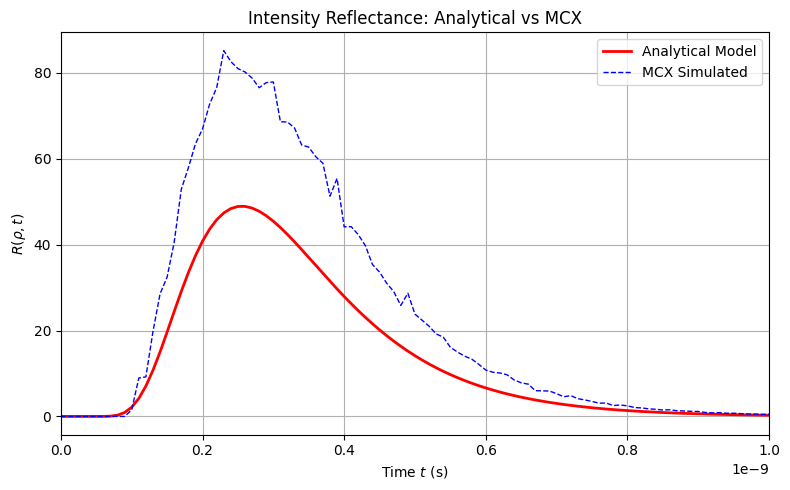

In [40]:
plt.figure(figsize=(8, 5))
# A_det

# intensity: fluence-rate (mm⁻² s⁻¹ photon⁻¹)
plt.plot(t_mcx, bin_counts_ana, 'r-', label="Analytical Model", linewidth=2)

# Plot MCX simulated data
plt.plot(t_mcx, sum_dref_per_time, 'b--', label="MCX Simulated", linewidth=1)

# Labels and title
plt.xlabel("Time $t$ (s)")
plt.ylabel(r"$R(\rho, t)$")
plt.title("Intensity Reflectance: Analytical vs MCX")
plt.xlim(0, 1e-9)
#plt.xlim(0, 0.2e-8)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
area_trapz   = np.trapz(bin_counts_ana, x=t_mcx)
print(f"Area (trapz)  = {area_trapz:.6g}")
area_trapz   = np.trapz(sum_dref_per_time, x=t_mcx)
print(f"Area (trapz)  = {area_trapz:.6g}")

Area (trapz)  = 1.43153e-08
Area (trapz)  = 2.40873e-08


<ipython-input-41-81954f6bd63c>:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_trapz   = np.trapz(bin_counts_ana, x=t_mcx)
<ipython-input-41-81954f6bd63c>:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_trapz   = np.trapz(sum_dref_per_time, x=t_mcx)


### Correct by reflection coefficient

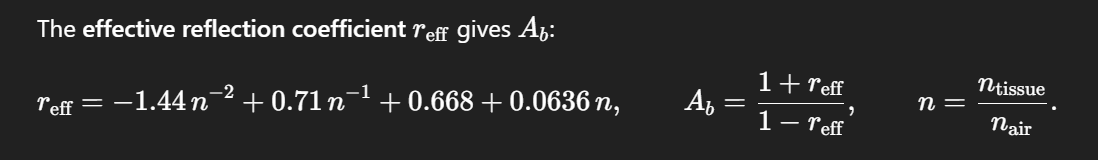

In [42]:
# relative refractive index, n = 1.370
n_rel = n / 1.0                         # tissue / air

# effective reflection coefficient
r_eff = -1.44/n_rel**2 + 0.71/n_rel + 0.668 + 0.0636*n_rel
print(r_eff)

# boundary factor
#A_b   = (1 + r_eff) / (1 - r_eff)
#print(A_b)

# corrected analytical reflectance
R_corr = bin_counts_ana * (1+ r_eff)

0.506157627364271


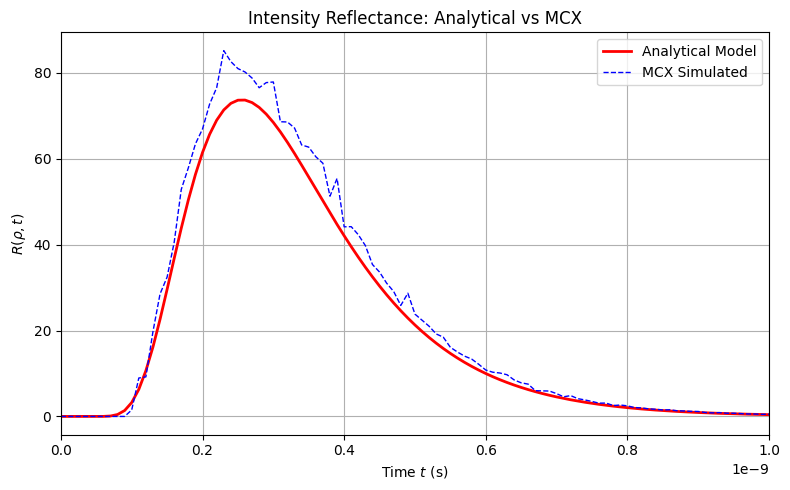

In [44]:
plt.figure(figsize=(8, 5))

# intensity: fluence-rate (mm⁻² s⁻¹ photon⁻¹)
plt.plot(t_mcx, R_corr, 'r-', label="Analytical Model", linewidth=2)

# Plot MCX simulated data
plt.plot(t_mcx, sum_dref_per_time, 'b--', label="MCX Simulated", linewidth=1)

# Labels and title
plt.xlabel("Time $t$ (s)")
plt.ylabel(r"$R(\rho, t)$")
plt.title("Intensity Reflectance: Analytical vs MCX")
plt.xlim(0, 1e-9)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Take Ln

$$
\ln R(\rho, t) = -\frac{3}{2} \ln(4 \pi D c) + \ln(z_0) - \frac{5}{2} \ln(t) - \mu_a c t - \frac{\rho^2 + z_0^2}{4 D c t}
$$

$$
\frac{d}{dt} \left[ \ln R(\rho, t) \right] = -\frac{5}{2t} - \mu_a c + \frac{\rho^2 + z_0^2}{4 D c t^2}
$$

In [45]:
D

0.24154589371980673

In [46]:
ln_intensity = -ua * c * t_mcx - (3/2) * np.log(4 * np.pi * D * c) + np.log(z0) - (5/2) * np.log(t_mcx) - ((rho**2 + z0**2) / (4 * D * c * t_mcx))

def get_ln_intensity(t):
    ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z0) - (5/2) * np.log(t) - ((rho**2 + z0**2) / (4 * D * c * t))
    return ln_intensity

<ipython-input-46-e509d99a6e89>:1: RuntimeWarning: divide by zero encountered in log
  ln_intensity = -ua * c * t_mcx - (3/2) * np.log(4 * np.pi * D * c) + np.log(z0) - (5/2) * np.log(t_mcx) - ((rho**2 + z0**2) / (4 * D * c * t_mcx))
<ipython-input-46-e509d99a6e89>:1: RuntimeWarning: divide by zero encountered in divide
  ln_intensity = -ua * c * t_mcx - (3/2) * np.log(4 * np.pi * D * c) + np.log(z0) - (5/2) * np.log(t_mcx) - ((rho**2 + z0**2) / (4 * D * c * t_mcx))
<ipython-input-46-e509d99a6e89>:1: RuntimeWarning: invalid value encountered in subtract
  ln_intensity = -ua * c * t_mcx - (3/2) * np.log(4 * np.pi * D * c) + np.log(z0) - (5/2) * np.log(t_mcx) - ((rho**2 + z0**2) / (4 * D * c * t_mcx))


<ipython-input-48-473df04609bf>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(t_mcx, np.log(sum_dref_per_time), 'b--', label="MCX Simulated", linewidth=1)


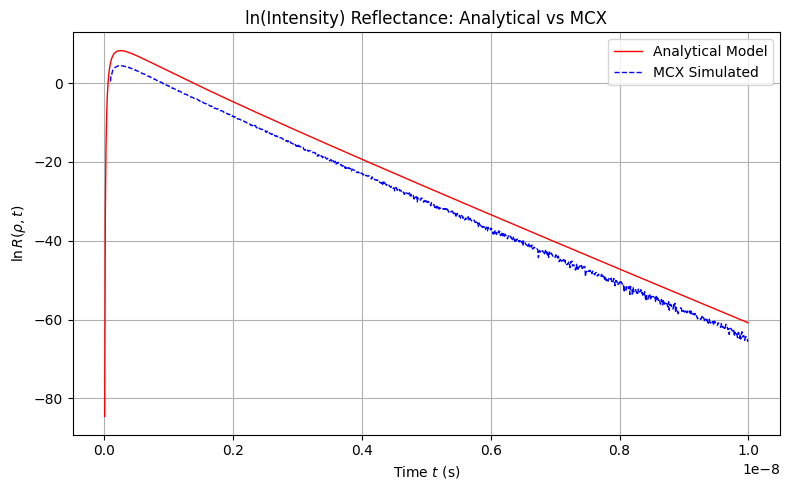

In [48]:
# Plot
plt.figure(figsize=(8, 5))

# Plot analytical model
plt.plot(t_mcx, ln_intensity, 'r-', label="Analytical Model", linewidth=1)

# Plot MCX simulated data
plt.plot(t_mcx, np.log(sum_dref_per_time), 'b--', label="MCX Simulated", linewidth=1)

# Labels and title
plt.xlabel("Time $t$ (s)")
plt.ylabel(r"$\ln R(\rho, t)$")
plt.title("ln(Intensity) Reflectance: Analytical vs MCX")

# Grid and legend
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Slop approximation

In [49]:
tstep = cfg['tstep']
ua_mcx = -(compute_slope(cfg['tstep'] * 100, np.log(sum_dref_per_time)[100], cfg['tstep']*350, np.log(sum_dref_per_time)[350]))/(c*10)
ua_the = -(compute_slope(cfg['tstep'] * 100, ln_intensity[100], cfg['tstep']*350, ln_intensity[350]))/(c*10)
print('ua_mcx=', ua_mcx,'/mm-1')
print('ua_the=',ua_the,'/mm-1')

ua_mcx= 0.0034883944 /mm-1
ua_the= 0.0034331961798881017 /mm-1


<ipython-input-49-8ba76cb9024e>:2: RuntimeWarning: divide by zero encountered in log
  ua_mcx = -(compute_slope(cfg['tstep'] * 100, np.log(sum_dref_per_time)[100], cfg['tstep']*350, np.log(sum_dref_per_time)[350]))/(c*10)


### FFT

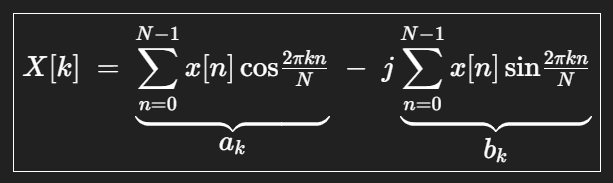

In [79]:
det_bin_abs = []
for t in range(res['dref'].shape[3]):
    dref_slice = res['dref'][:, :, 0, t]
    masked_values = dref_slice[det_mask]
    mean_val = np.sum(masked_values) * 1e8 * tstep
    det_bin_abs.append(mean_val)
print(len(det_bin_abs))

### src
src = np.zeros_like(det_bin_abs)
src[0] = 1e8

FFT_src = np.fft.fft(src)
FFT_det = np.fft.fft(det_bin_abs)
freq = np.fft.fftfreq(len(det_bin_abs), d=tstep)

1000


In [81]:
f0   = 500e6
k    = np.argmin(np.abs(freq - f0))
print(k)
Uac_src_abs = 2 * np.abs(FFT_src[k]) / len(det_bin_abs)    #  ≈ nphoton * 2/N
Uac_det_abs = 2 * np.abs(FFT_det[k]) / len(det_bin_abs)     #  photons · s^-1  at 500 MHz
phase       =       np.angle(FFT_det[k])    #  radians
print("Src amplitude  (phot/s):", Uac_src_abs)
print("Det amplitude  (phot/s):", Uac_det_abs)
print("Phase lag (rad):", phase)

5
Src amplitude  (phot/s): 200000.0
Det amplitude  (phot/s): 4.345401
Phase lag (rad): -1.0465213
